# Part 2: Further Data Cleaning and Machine Learning Models

Upon examining the graphs and the input for machine learning models, I realized there was more to do with regards to data cleaning.

This second round of cleaning was focused on columns that require recoding due to the need for binary variables, categorical variables in place of nominal values, data that are in arrays, and data with values that don't necessarily make sense. The respective variables and rationales for recording are listed below:

**Binary variables (0,1) needed**
- host_is_superhost
- host_has_profile_pic
- host_identity_verified
- instant_bookable

**Values need categories**
- cancellation_policy
- room_type
- property_type
- neighbourhood
- host_response_time

**Values are in arrays**
- amenities
- host_verifications

**Values need to make sense**
- price values should be > 0

In [589]:
import sys
import datetime
import pandas as pd
import matplotlib as ml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection, datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

%matplotlib inline

data = pd.read_csv('new_filtered_data.csv', encoding = "ISO-8859-1")

### Binary Variables

The first data recoding that can be done is for columns that currently have 't' and 'f' values. These variables will become more useable in regression and machine learning models if they were represented as 0 and 1. I have thus used the map method to convert them to 0 for false and 1 for true. I could have also used the apply lambda:x method for this as well.

In [590]:
# Binary variables (0,1) needed

# host_is_superhost
# host_has_profile_pic
# host_identity_verified
# instant_bookable

binary_vars = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable']
for var in binary_vars:
    data[var] = data[var].map({'t': 1, 'f': 0})
data[binary_vars].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,instant_bookable
0,0,1,1,0
1,0,1,0,1
2,1,1,1,1
3,0,1,0,0
4,0,1,1,1


### Numerical Categories

There are certain columns that have categorical data that can be recoded into numerical categories so that they are more useable in machine learning models. Of the columns listed above, the 'neighbourhood' column has the most unique values at 56 and this column will be dealth with later once I am more familar with grouping techniques and the geographical grouping of San Francisco.

I first ran value_counts() on all the other columns that I am recoding to see what the unique values are. This gives me a better idea of what the unique variables are and the presence of problems such as class imbalance.

### Doing the same binary converting and numerical categories with scikit-learn
I later learnt that the same mapping functions that I've been performing for all of these columns could be achieved through scikit-learn and other panda functions as well.

Some methods are as follows:
1. I could have changed the type of the column to "category" with the astype('type') method. I could then have used cat.codes to label them.
2. I could have used one hot encoding as well to assign a new column to each unique value. the get_dummies method could be used to create such dummy columns. This method however could be an issue if there are too many categories to deal with, such as neighbourhood. That would create too many new columns and take up unecessary space.
3. There are also methods through scikit-learn to create these new columns, such as fit_tranform and label binarizer and the resulting columns would have to be joined back to the original table. 

As these values have already been sorted with the mapping function, the current new columns will be used in their current states.

In [591]:
# Values need categories

# cancellation_policy
# room_type
# property_type
# neighbourhood
# host_response_time

data['cancellation_policy'].value_counts()

strict             3095
moderate           2258
flexible           1348
super_strict_30      17
super_strict_60       2
Name: cancellation_policy, dtype: int64

In [592]:
data['cancellation_recoded'] = data['cancellation_policy'].map({'strict': 0, 'moderate': 1, 'flexible':2, 'super_strict_30':3, 'super_strict_60':4})
data['cancellation_recoded'].head()

0    1
1    0
2    2
3    1
4    1
Name: cancellation_recoded, dtype: int64

In [593]:
data['room_type'].value_counts()

Entire home/apt    4007
Private room       2603
Shared room         110
Name: room_type, dtype: int64

In [594]:
data['room_type_recoded'] = data['room_type'].map({'Entire home/apt': 0, 'Private room': 1, 'Shared room':2})
data['room_type_recoded'].head()

0    1
1    0
2    0
3    0
4    0
Name: room_type_recoded, dtype: int64

In [595]:
data['property_type'].value_counts()

Apartment             3531
House                 2083
Condominium            503
Loft                    94
Other                   85
In-law                  67
Bed & Breakfast         64
Guest suite             56
Townhouse               49
Dorm                    35
Boutique hotel          31
Guesthouse              28
Timeshare               25
Hostel                  19
Camper/RV               13
Bungalow                12
Cabin                    8
Boat                     5
Castle                   5
Treehouse                2
Villa                    2
Cave                     1
Serviced apartment       1
Tent                     1
Name: property_type, dtype: int64

In [596]:
data['property_type_recoded'] = data['property_type'].map({'Apartment': 0, 'House': 1, 'Condominum':2})
data['property_type_recoded'].fillna(3, inplace=True)
data['property_type_recoded'] = data['property_type_recoded'].astype('int64')
data['property_type_recoded'].head()

0    1
1    0
2    1
3    1
4    0
Name: property_type_recoded, dtype: int64

In [597]:
data['host_response_time'].value_counts()

within an hour        3247
within a few hours    1339
within a day           729
a few days or more      52
Name: host_response_time, dtype: int64

In [598]:
data['response_recoded'] = data['host_response_time'].map({'within an hour': 0, 'within a few hours': 1, 'within a day':2, 'a few days or more':3})
data['response_recoded'].fillna(4, inplace=True)
data['response_recoded'] = data['response_recoded'].astype('int64')
data['response_recoded'].head()

0    0
1    0
2    0
3    1
4    0
Name: response_recoded, dtype: int64

### Values are in Arrays

Amenities and host_verifications are both columns in which most of the values are in the form of an array. There are thus multiple different combinations of amenities and verification methods available that differentiate each host. In my opinion the best way to intepret these columns would be to split the string and record them as individual "words" that contain the type of amenities and verification methods. 

These two variables are however unlikely to be of large significance to the dependent variable of price that we are examining in later models. Furthermore, as the below screenshots show, a listing with 6 amenities could cost 250 USD a night while another with 26 amenities could cost 10 USD a night. 
<img src="6_amenities.png" width = 500px>
<img src="26_amenities.png" width = 500px>

These two columns will be dropped from the model analysis for now but the method to clean them and aggregate the information in them will be done later.

### Values need to make sense

While there are certain values like number of beds or bedrooms that are 0, those instances could theoretically be possible if it was a futon or if it was a studio without a bedroom. We will thus only be dropping entries for which the price is 0 for now.

In [599]:
# Values need to make sense

# price values should be > 0

data = data.drop(data[(data['price']==0)].index)
data.shape

(6699, 50)

### Dropping zipcode and neighbourhood rows

There is still the carry-over data from the previous cleaning session in which neighbourhood and zipcode entries were left in the data set. 

There are definitely ways to fill in such values. One possible way that comes to mind is running a categorical supervised machine learning model to predict such values as the longitude and latitude values are likely to be near perfect predictors of which zipcode or neighbourhood a listing is in.

I have yet to learn how to fillna with the results of a machine learning model and since the missing entries make up around 1% of the initial data entries, these missing neighbourhood and zipcode entries will be dropped for now.

In [600]:
data = data.dropna(axis=0, subset=[['neighbourhood', 'zipcode']])
data.shape

(6610, 50)

### Recoding price bands for categorical analysis

To construct a supervised model based on categorical values, the variable of price has to be recoded such that it falls into certain categories. 

In [601]:
data['price_per_bed']=data['price']/data['beds']
data['price_per_bed'].head()

0    120.0
1     59.0
2    159.0
3    250.0
4    169.0
Name: price_per_bed, dtype: float64

In [602]:
data['price_per_bed'].describe()

count     6610.000000
mean       130.965284
std        182.987576
min          5.000000
25%         80.000000
50%        110.000000
75%        150.000000
max      10000.000000
Name: price_per_bed, dtype: float64

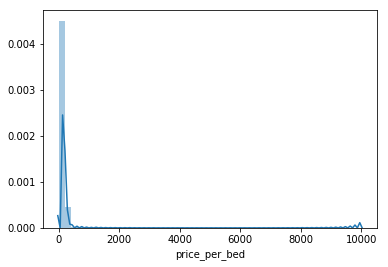

In [603]:
sns.distplot(data['price_per_bed'])

In [604]:
np.percentile(data['price_per_bed'], np.arange(0, 100, 5))

array([   5.        ,   46.93125   ,   59.        ,   66.33333333,
         75.        ,   80.        ,   86.        ,   90.        ,
         98.33333333,  100.        ,  110.        ,  119.        ,
        125.        ,  133.33333333,  145.        ,  150.        ,
        168.2       ,  187.5       ,  204.        ,  250.        ])

In [605]:
data['price_tiers'] = pd.cut(data['price_per_bed'], [0, 20, 50, 100, 200, 10000], labels=[1,2,3,4,5])
data['price_tiers'].head()

0    4
1    3
2    4
3    5
4    4
Name: price_tiers, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [606]:
data['price_tiers'].value_counts()

4    2874
3    2587
5     666
2     460
1      23
Name: price_tiers, dtype: int64

As noted previously, entries for descriptions are left intact for now for a potential NLP analysis later. The dataframe after this second round of cleaning comes in at 6610 rows, including an additional 4 recoded columns.

In [607]:
data.count()

Unnamed: 0                     6610
id                             6610
name                           6610
summary                        6610
space                          5133
access                         4612
interaction                    4471
house_rules                    4938
host_response_time             5276
host_is_superhost              6610
host_listings_count            6610
host_verifications             6610
host_has_profile_pic           6610
host_identity_verified         6610
neighbourhood                  6610
zipcode                        6610
latitude                       6610
longitude                      6610
property_type                  6610
room_type                      6610
accommodates                   6610
bathrooms                      6610
bedrooms                       6610
beds                           6610
bed_type                       6610
amenities                      6610
price                          6610
security_deposit            

### Revisiting the multiple linear regression model from Part 1

Back in part 1, we constructed a linear regression model from existing numerical variables. We repeat the same process with the recoded data to see if it explain 30 day availability better with these new factors.

As can be seen from the resulting model, the R^2 value, although still relatively small at 0.134 is a huge improvement on the previous result. It can also be seen that whether a host is a superhost and the number of reviews received are insignificant in terms of determining 30 day availability. 

In [608]:
y = data['availability_30']
X = data[['cancellation_recoded', 'room_type_recoded', 'property_type_recoded', 'response_recoded', 'review_scores_rating', 'host_is_superhost','number_of_reviews','accommodates','bathrooms','bedrooms','years_being_host','minimum_nights']]
X = sm.add_constant(X)
model11 = sm.OLS(y, X).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        availability_30   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     85.16
Date:                Thu, 22 Feb 2018   Prob (F-statistic):          7.04e-196
Time:                        13:42:25   Log-Likelihood:                -23329.
No. Observations:                6610   AIC:                         4.668e+04
Df Residuals:                    6597   BIC:                         4.677e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    15.8569      1.454     10.907      0.000      13.007      18.707
cancellation_recoded     -0.7561      0.138     -5.475      0.000      -1.027      -0.485
room_type_recoded         2.7582      0.229     12.070      0.000       2.310       3.206
property_type_recoded     0.5634      0.098      5.769      0.000       0.372       0.755
response_recoded         -1.5656      0.073    -21.541      0.000      -1.708      -1.423
review_scores_rating     -0.0873      0.015     -5.870      0.000      -0.116      -0.058
host_is_superhost        -0.2082      0.254     -0.818      0.413      -0.707       0.291
number_of_reviews        -0.0014      0.002     -0.679      0.497      -0.006       0.003
accommodates              0.4723      0.085      5.579      0.000       0.306       0.638
bathrooms                 0.4329      0.189      2.292      0.022       0.063       0.803
bedrooms                 -0.8622      0.179     -4.823      0.000      -1.213      -0.512
years_being_host         -0.1446      0.055     -2.622      0.009      -0.253      -0.037
minimum_nights            0.0234      0.006      3.869      0.000       0.012       0.035
==============================================================================
Omnibus:                     1009.762   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1532.389
Skew:                           1.117   Prob(JB):                         0.00
Kurtosis:                       3.755   Cond. No.                     1.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Machine Learning Model: Supervised Categorical

The first set of predictive models are constructed on the relationship between certain variables and the price tier of the particular listing. With the now recoded data, I went about creating a list of predictive variables:
<img src="listing_selection.png" width = 1000px>

A look at the listing information from the airbnb and airbnb listing information pages show that there are a few variables that are immediately present:
- room_type
- beds
- name
- price
- cancellation_policy
- review_scores_rating
- host_is_superhost
- neighbourhood

I have thus taken this list of "first impression" variables and added 
The data columns I have chosen for this model are thus:
- cancellation_recoded
- room_type_recoded
- property_type_recoded
- response_recoded
- beds
- bathrooms
- bedrooms
- accommodates
- review_scores_rating
- host_is_superhost

The target variable for testing is 'price_tiers' with the following code interpretation:
- 1: Prices per bed ranging from 0-20, can be interpreted as the "bargain" tier
- 2: Prices per bed ranging from 20-50, can be interpreted as the "affordable" tier
- 3: Prices per bed ranging from 50-100, can be interpreted as the "business" tier
- 4: Prices per bed ranging from 100-200, can be interpreted as the "premium" tier
- 5: Prices per bed ranging from 200-10000, can be interpreted as the "luxury" tier

My initial hypothesis was that there was a positive correlation between the feature variables chosen and the dependent variable. It is usually the larger premium homes that are able to accomodate more people and the number of beds, bathrooms, and bedrooms would be naturally higher for such homes as well. Such premium homes were thus likely to belong to a higher price tier, even when only considering price per bed. 

There could be an issue of some of the categories being somewhat misleading, especially cancellation_recoded as there wasn't necessarily a tiered relationship between the variables. Such problems could be solved with one hot encoding methods but to save RAM space and not take up too much memory, the current method was used. 

In [609]:
data['price_tiers'].value_counts()

4    2874
3    2587
5     666
2     460
1      23
Name: price_tiers, dtype: int64

In [610]:
#a new dataframe is created with the data used to predict the target variable "price_tiers"
category_data = data[['cancellation_recoded', 'room_type_recoded', 'property_type_recoded', 'response_recoded', 'beds', 'bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating', 'host_is_superhost']]
category_data.head()

,cancellation_recoded,room_type_recoded,property_type_recoded,response_recoded,beds,bathrooms,bedrooms,accommodates,review_scores_rating,host_is_superhost
0,1,1,1,0,1,1.0,1,2,95,0
1,0,0,0,0,5,2.0,3,7,92,0
2,2,0,1,0,1,1.0,1,2,98,1
3,1,0,1,1,3,3.5,3,6,97,0
4,1,0,0,0,1,1.0,1,2,100,0


**There is the constant issue of overfitting the data and I have learnt instances along to way of how to deal with overfitting. Some initial measures are to understand the training-test split proportion and the use of cross validation techniques.**

Arguable the most important part of building a predictive model is deciding what kind of model to use. With limited experience in such models, I mostly deferred to articles on the web for more information.

I looked at http://scikit-learn.org/stable/modules/ensemble.html for information regarding the ensemble module.
I also looked at https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-choice and https://blog.socialcops.com/engineering/machine-learning-python/ for a beginner's guide to machine learning and the different types of models available.

Having been an avid listener of the Data Skeptics podcast I had a basic idea of the underlying theory behind some of the models. For the variables that were chosen, I had initially expected a linear relationship. As explained above, my initial hypothesis was that the price tier of the listing will be higher if there were more rooms or it had a higher rating. It seemed like a decision tree classifier, neural network, and logistic regression were most applicable for the problem at hand. 

I also tried my hand at random forest classifier as it was a common model that prevents overfitting. From what I understood about random forest, it took subsets with randomly generated data and the results from the subset all "voted" towards a final result.

In [611]:
X = category_data
y = data['price_tiers']

#cross validation is a measure against overfitting. Overfitting means that we have mapped the model too well
#to existing data and that it is likely not very useful for external, unseen data.
#cross validation works by creating multiple training and testing sets splits, holding one test set for each "fold",
#performing a test for that internal test set, and aggregating the results across the "folds"
#train_test_split splits the data into a training set and a testing set. 
#The rationale behind this is to ensure that the model has "unseen" data to test on.
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.3)

In [686]:
#arrays to append all the results to
models = []
scores = []
clf_dt = tree.DecisionTreeClassifier(max_depth=10)
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)
models.append('Decision Tree')
scores.append(clf_dt.score (X_test, y_test))

In [628]:
clf_rf = ske.RandomForestClassifier(n_estimators=100)
clf_rf.fit (X_train, y_train)
clf_rf.score (X_test, y_test)
models.append('Random Forest')
scores.append(clf_rf.score (X_test, y_test))

In [630]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(solver='adam', hidden_layer_sizes=(1000), )
clf_nn.fit(X_train, y_train)
clf_nn.score(X_test, y_test)
models.append('Neural Network')
scores.append(clf_nn.score (X_test, y_test))

In [631]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
clf_lr.score (X_test, y_test)
models.append('Logistic Regression')
scores.append(clf_lr.score (X_test, y_test))

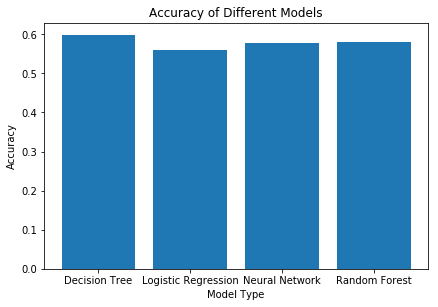

In [639]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(models,scores)
plt.tight_layout()
plt.title('Accuracy of Different Models')
plt.ylabel('Accuracy')
plt.xlabel('Model Type')
plt.show()

It seems that Decision Tree is the best model to be used in this case, with the highest accuracy out of the models chosen. The accuracy comes in at around 0.6, which admittedly isn't a high accuracy rate.

## Ways to Improve Model

The final accuracy rate of 0.6 is certainly not ideal and more could be done to the model and the feature variables chosen to improve the results of the model. Here, I tried to recode neighborhood variables and include all given variables as feature variables to see if it improved the model under the decision tree model.

In [616]:
data['neighbourhood_codes']=data['neighbourhood'].astype('category')

In [617]:
data['neighbourhood_codes'].dtype

category

In [618]:
data['neighbourhood_codes']=data['neighbourhood_codes'].cat.codes

In [619]:
data['neighbourhood_codes'].head()

0    43
1    41
2    41
3    43
4    41
Name: neighbourhood_codes, dtype: int8

In [669]:
category_data = data[['neighbourhood_codes', 'cancellation_recoded', 'room_type_recoded', 'property_type_recoded', 'response_recoded', 'beds', 'bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating', 'host_is_superhost', 'host_listings_count', 'security_deposit', 'cleaning_fee', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'extra_people', 'years_being_host', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

In [670]:
X = category_data
y = data['price_tiers']

In [684]:
models = []
scores = []
clf_dt = tree.DecisionTreeClassifier(max_depth=10)
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)
models.append('Decision Tree')
scores.append(clf_dt.score (X_test, y_test))

In [685]:
models, scores

(['Decision Tree'], [0.60060514372163387])

However, as can be seen in the resulting score, the accuracy of the model remains around the 0.6 mark and the adding of the other variable did not seem to improve the accuracy of the model. The following are possible reasons why this is a poor model and what else could be done to improve the model:
1. The neighbourhood category could be better categorized into larger geographical areas as there are many areas with barely any data where a neighbourhood like Mission dominates around 10% of the data. There is thus a class imbalance problem that could lead to biased results.
2. The landing page for Airbnb includes the pictures of the listings as well and perhaps image recognition or color analysis could be conducted to find out if the type of picture boosted the model accuracy.
3. Many of the categorical codes were rather simplistic with values ranging from 0 to 4 for example. The model might have taken the value of the categorical codes as values and weighted them accordingly. One hot encoding might have been a better option in terms of reducing this bias but for columns with too many categories this could lead to too many new columns and not enough RAM. A better understanding of individual variables and how they cluster together could help in narrowing down certain variables into more applicable categories. 
4. With the addition of additional variables, the current seemingly linear relationship might no longer hold and other models might become more useful. As my current knowledge of such models still remain limited, I would be better able to choose the model to use with a deeper understanding behind the running of different non-linear models.
5. There is a heavy skewing of price data, with many being bucketed in tiers 3 and 4. This seems to be a class imbalance issue and perhaps the tier-ing of price could be done in a better way to fit with the decile values obtained of the data.

## Next Steps

While this was certainly an interesting initial dive into using Python for machine learning, much should still be learned including and not limited to the following:
1. Learning NLP to do sentiment analyses
2. A familiarization with model theories and use cases
3. A better use of data cleansing techniques to deal with outliers and categorizing variables
4. A better understanding of other techniques to reduce overfitting including boosting or aggregating models
5. Deepening domain knowledge to better categorize continuous variables and understand analytical results
6. Diving into regression based supervised learning which could be an interesting alternative to determining price or availability of the listing
7. Forming a more concrete and business specific model target for the next model

Ultimately, this was definitely a fun experience launching head-first into learning Python and data science. It was a valuable experience that really highlighted the technical capability required of the models themselves and the domain knowledge and business creativity needed for selecting and cleaning feature variables. 

This is certainly just the start of the journey and I am definitely looking forward to tackling more of the areas of improvement previously mentioned!